# Figure 6
1. In silico generalisation
2. In vivo variance
3. Wdf mean

In [1]:
from utils import *
from plot_params import *
from scipy.stats import pearsonr, kurtosis
from scikit_posthocs import posthoc_dunn
from scipy.stats import iqr
from scipy.special import xlogy

In [2]:
save = True
savepath = r'D:\Data\DeepMouse\Figures\Figure6'

## 1. In silico generalisation

In [3]:
# Plot functions
def unpack_data(activation, regions, predictions, masks, prob, N=200, mode='mean'):
    '''Given a dictionary of activations, unpack the dictionary, and calculate the average activity'''
    out = []
    all_data = np.concatenate([activation[region] for region in regions])
    scaler = StandardScaler()
    scaler.fit(all_data)
    for i, region in enumerate(regions):
        data = activation[region]
        data = data[predictions[i]]
        data = scaler.transform(data)
        # Take only most representative
        idx = np.argsort(prob[region][masks[i]])[-N:]
        if mode == 'mean': out.append(data[masks[i]][idx].mean(axis=1))
        elif mode == 'l2': out.append(np.linalg.norm(data[masks[i]][idx],axis=1))
        elif mode == 'var': out.append(data[masks[i]][idx].var(axis=0))
        elif mode == 'popvar': out.append(data[masks[i]][idx].var(axis=1))
        elif mode == 'entropy': out.append(get_entropy(data[masks[i]][idx], binrange=([-3,3])))
        elif mode == 'kurtosis': out.append(kurtosis(data[masks[i]][idx], axis=0))
        elif mode == 'minmax': out.append(np.max(data[masks[i]][idx], axis=0)-np.min(data[masks[i]], axis=0))
        elif mode == 'minmax': out.append(iqr(data[masks[i]][idx], axis=0))
        elif mode == '25p': out.append(np.percentile(data[masks[i]][idx], 10, axis=0))
        elif mode == '75p': out.append(np.percentile(data[masks[i]][idx], 90, axis=0))

        else: raise
    return out

def get_entropy(X, binrange=([-3,3])):
    '''Calculate the von Neumann entropy'''
    N = 1000
    bins = np.linspace(binrange[0], binrange[1], N)
    dbin = bins[1]-bins[0]
    entropy = np.array([shannon_entropy(np.histogram(X[:,i], bins=bins, density=True)[0]*dbin)/np.log(N) for i in range(X.shape[1])])
    return entropy 

def shannon_entropy(x):
    return -np.sum(xlogy(x,x))

def plot_generalisation(activity, regions, figsize=(6,5), ylabel=''):
    '''Plot a list of boxplots'''
    fig, ax = pl.subplots(figsize=figsize)
    xticks = []
    for i, region in enumerate(regions):
        x = np.arange(len(regions)) + i*(len(regions)+1.5) + 1
        xticks.append(x)
    
    xticks = np.array(xticks).T
    lw = 0.5
    for i, region in enumerate(regions):
        bp1 = ax.boxplot(activity[i], showfliers=False, positions=xticks[i], widths=0.6, 
                     patch_artist=True, medianprops=dict(color='k', linewidth=lw), boxprops=dict(linewidth=lw), whiskerprops=dict(linewidth=lw),
                     capprops=dict(linewidth=lw))

        for patch, color in zip(bp1['boxes'], colors):
            patch.set_facecolor(colors[i])

    ax.set_ylabel(ylabel)
    ax.set_xlim(0, np.concatenate(xticks).max()+1)
    ax.set_xticklabels(['']*6*len(regions))
    ax.set_xticks([])

    return fig

def plot_matrix(activity, regions, figsize=(6,5), ylabel=''):
    '''Plot pairwise stats as matrix'''
    # Convert data to matrix
    mat = np.zeros((len(regions), len(regions)))
    for i in range(len(activity)):
        for j in range(len(activity)):
            mat[i,j] = np.median(activity[i][j])

    fig, ax = pl.subplots(figsize=figsize)
    ax.imshow(mat, cmap='gray', vmin=mat.min(), vmax=mat.max())

    # for i in range(len(regions)):
    #     for j in range(len(regions)):
    #         if mat[i,j] < 0.5: color = [0]*3
    #         else: color = [1] * 3
    #         ax.text(j,i, f"{data_m[i,j]:.2f}\n±{data_s[i,j]:.2f}", ha='center', va='center', size=6, color=color)

    ax.set_xticks(range(mat.shape[0]))
    ax.set_xticklabels(regions)
    ax.set_yticks(range(mat.shape[0]))
    ax.set_yticklabels(regions)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    return fig

def plot_generalisation_simplified(activity, regions, figsize=(6,5), ylabel='', ylim=None, yticks=None):
    '''Plot a list of boxplots'''
    fig, ax = pl.subplots(figsize=figsize)

    lw = 0.5
    for i in range(len(regions)):
        data = [activity[i][i], np.concatenate([activity[i][j] for j in range(len(activity[i])) if j != i])]
        print(f"{regions[i]}: {mannwhitneyu(data[0],data[1])}")
        bp1 = ax.boxplot(data, showfliers=False, positions=np.arange(1,3)+i*2+i, widths=0.6, 
                        patch_artist=True, medianprops=dict(color='k', linewidth=lw), boxprops=dict(linewidth=lw), whiskerprops=dict(linewidth=lw),
                        capprops=dict(linewidth=lw))

        cs = [colors[i], [.4]*3]
        for patch, color in zip(bp1['boxes'], cs):
            patch.set_facecolor(color)

    ax.set_ylabel(ylabel)
    ax.set_xlim(0,len(regions)*2+len(regions))
    ax.set_xticks(np.arange(1.5, (len(regions))*3, 3))
    ax.set_xticklabels(regions)
    if ylim is not None:
        ax.set_ylim(ylim)
    if yticks is not None:
        ax.set_yticklabels(yticks)

    return fig

def plot_generalisation_single(activity, regions, figsize=(6,5), ylabel=''):
    '''Plot a list of boxplots'''
    fig, ax = pl.subplots(figsize=figsize)

    lw = 0.5
    for i in range(len(regions)):
        data = [activity[i][i]/np.concatenate([activity[i][j] for j in range(len(activity[i])) if j != i]).mean(axis=0)]
        bp1 = ax.boxplot(data, showfliers=False, positions=[1+i*2+i], widths=0.6, 
                        patch_artist=True, medianprops=dict(color='k', linewidth=lw), boxprops=dict(linewidth=lw), whiskerprops=dict(linewidth=lw),
                        capprops=dict(linewidth=lw))

        cs = [colors[i]]
        for patch, color in zip(bp1['boxes'], cs):
            patch.set_facecolor(color)

    ax.set_ylabel(ylabel)
    ax.set_xlim(0,len(regions)*2+len(regions))
    ax.set_xticks(np.arange(1.5, (len(regions))*3, 3))
    ax.set_xticklabels(regions)

    return fig

def test_significance(data):
    '''Perform kruskal wallis with post hoc dunns'''
    # Sort data correctly
    stats = []
    for i in range(len(data)):
        d = []
        for j in range(len(data)):
            d.append(data[j][i])
        stats.append(posthoc_dunn(d, p_adjust='bonferroni'))
    return stats
    
def plot_percentile(activity25, activity75, regions, figsize=(6,5), ylabel='', ylim=None, yticks=None):
    '''Plot a list of boxplots'''
    fig, ax = pl.subplots(figsize=figsize)

    lw = 0.5
    for i in range(len(regions)):
        data25 = [activity25[i][i], np.concatenate([activity25[i][j] for j in range(len(activity25[i])) if j != i])]
        bp1 = ax.boxplot(data25, showfliers=False, positions=np.arange(1,3)+i*2+i, widths=0.6, 
                        patch_artist=True, medianprops=dict(color='k', linewidth=lw), boxprops=dict(linewidth=lw), whiskerprops=dict(linewidth=lw),
                        capprops=dict(linewidth=lw))

        cs = [colors[i], [.4]*3]
        for patch, color in zip(bp1['boxes'], cs):
            patch.set_facecolor(color)

    for i in range(len(regions)):
        data75 = [activity75[i][i], np.concatenate([activity75[i][j] for j in range(len(activity75[i])) if j != i])]
        bp1 = ax.boxplot(data75, showfliers=False, positions=np.arange(1,3)+i*2+i, widths=0.6, 
                        patch_artist=True, medianprops=dict(color='k', linewidth=lw), boxprops=dict(linewidth=lw), whiskerprops=dict(linewidth=lw),
                        capprops=dict(linewidth=lw))

        cs = [colors[i], [.4]*3]
        for patch, color in zip(bp1['boxes'], cs):
            patch.set_facecolor(color)

    ax.set_ylabel(ylabel)
    ax.set_xlim(0,len(regions)*2+len(regions))
    ax.set_xticks(np.arange(1.5, (len(regions))*3, 3))
    ax.set_xticklabels(regions)
    if ylim is not None:
        ax.set_ylim(ylim)
    if yticks is not None:
        ax.set_yticklabels(yticks)

    return fig
    

In [4]:
# Load activations
fp_cross = r'D:\Data\DeepMouse\Results\generalisation'
fp_nc = r'D:\Data\DeepMouse\Results\noise_ceiling'
activations = [np.load(os.path.join(fp_cross, f"cross_presentation_{region}.npy"), allow_pickle=True).item() for region in regions]

# Load predictions
predictions = [load_performance(fp_nc, region) > 0.3 for region in regions]

# Load representative probabilities
fp_prob = r'D:\Data\DeepMouse\Results\representative_images\raw_probabilities.npy'
prob = np.load(fp_prob, allow_pickle=True).item()

# Get masks
fp_opt = r'D:\Data\DeepMouse\Results\optstims\RF_aligned'
masks = [np.load(os.path.join(fp_opt, f'good_optstim_{region}.npy')) for region in regions]

N = 2000
activity_mean = [unpack_data(activation, regions, predictions, masks, prob, N=N, mode='mean') for i, activation in enumerate(activations)]
activity_l2 = [unpack_data(activation, regions, predictions, masks, prob, N=N, mode='l2') for i, activation in enumerate(activations)]
activity_var = [unpack_data(activation, regions, predictions, masks, prob, N=N, mode='var') for i, activation in enumerate(activations)]
activity_popvar = [unpack_data(activation, regions, predictions, masks, prob, N=N, mode='popvar') for i, activation in enumerate(activations)]
activity_25 = [unpack_data(activation, regions, predictions, masks, prob, N=N, mode='25p') for i, activation in enumerate(activations)]
activity_75 = [unpack_data(activation, regions, predictions, masks, prob, N=N, mode='75p') for i, activation in enumerate(activations)]

activity_kur = [unpack_data(activation, regions, predictions, masks, prob, N=N, mode='kurtosis') for i, activation in enumerate(activations)]
activity_minmax = [unpack_data(activation, regions, predictions, masks, prob, N=N, mode='minmax') for i, activation in enumerate(activations)]
activity_entr = [unpack_data(activation, regions, predictions, masks, prob, N=N, mode='entropy') for i, activation in enumerate(activations)]

for i in range(len(regions)):
    m, s = np.concatenate(activity_l2[i]).mean(), np.concatenate(activity_l2[i]).std()
    for j in range(len(activity_l2[i])):
        activity_l2[i][j] = (activity_l2[i][j]-m)/s


In [5]:
print(np.sum([i.sum() for i in predictions]))

7266


V1: MannwhitneyuResult(statistic=6016366.5, pvalue=1.477263390978963e-243)
LM: MannwhitneyuResult(statistic=4525976.0, pvalue=2.081518351267267e-21)
LI: MannwhitneyuResult(statistic=3351319.0, pvalue=2.93565563602669e-06)
POR: MannwhitneyuResult(statistic=3357650.0, pvalue=6.795215151433349e-10)
AL: MannwhitneyuResult(statistic=4807986.5, pvalue=4.083769282092384e-87)
RL: MannwhitneyuResult(statistic=3373422.0, pvalue=5.617038301815293e-43)


c:\Users\rudit\anaconda3\envs\mnp_torch\lib\site-packages\ipykernel_launcher.py:117: UserWarning: FixedFormatter should only be used together with FixedLocator


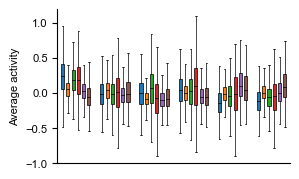

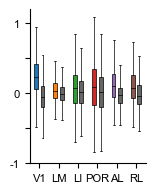

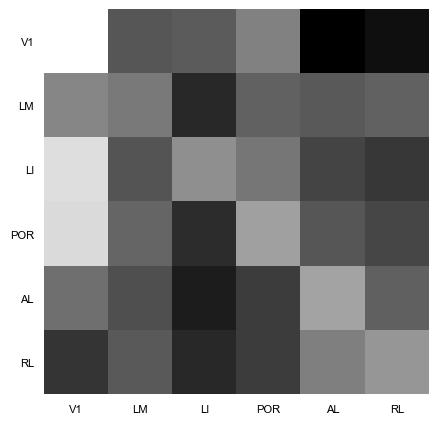

In [6]:
fig1 = plot_generalisation(activity_mean, regions, figsize=(3,2), ylabel='Average activity')
stats_mean = test_significance(activity_mean)
# for i in range(len(stats_mean)): 
#     print(stats_mean[i][i+1] < 0.05)

fig11 = plot_generalisation_simplified(activity_mean, regions, figsize=(1.5,2), ylabel='', ylim=(-1,1.2), yticks=['-1','','0','','1'])

fig12 = plot_matrix(activity_mean, regions, figsize=(5,5), ylabel='Average activity')

if save:
    fig11.savefig(os.path.join(savepath, 'average_activity.eps'), bbox_inches='tight')

V1: MannwhitneyuResult(statistic=5865341.0, pvalue=1.076507031447403e-211)
LM: MannwhitneyuResult(statistic=5055175.5, pvalue=9.234184945508531e-68)
LI: MannwhitneyuResult(statistic=3931347.0, pvalue=4.643318317487897e-47)
POR: MannwhitneyuResult(statistic=4521968.0, pvalue=1.4087486148137733e-148)
AL: MannwhitneyuResult(statistic=5709690.5, pvalue=1.522263123811701e-251)
RL: MannwhitneyuResult(statistic=3683973.0, pvalue=9.639969055370697e-84)


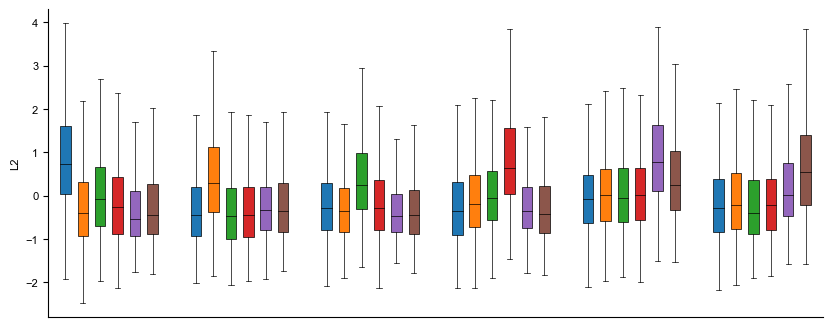

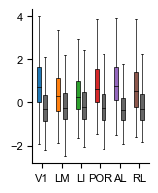

In [7]:
_=plot_generalisation(activity_l2, regions, figsize=(10,4), ylabel='L2')
fig9 = plot_generalisation_simplified(activity_l2, regions, figsize=(1.5,2), ylabel='')

if save:
    fig9.savefig(os.path.join(savepath, 'L2_activity.eps'), bbox_inches='tight')


V1: MannwhitneyuResult(statistic=9020371.0, pvalue=0.0)
LM: MannwhitneyuResult(statistic=9458429.0, pvalue=0.0)
LI: MannwhitneyuResult(statistic=5107484.0, pvalue=4.361633207992424e-259)
POR: MannwhitneyuResult(statistic=5178573.5, pvalue=0.0)
AL: MannwhitneyuResult(statistic=8279980.0, pvalue=0.0)
RL: MannwhitneyuResult(statistic=3738867.0, pvalue=0.0)


c:\Users\rudit\anaconda3\envs\mnp_torch\lib\site-packages\ipykernel_launcher.py:117: UserWarning: FixedFormatter should only be used together with FixedLocator


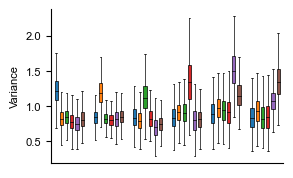

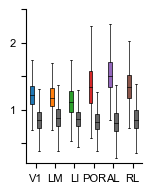

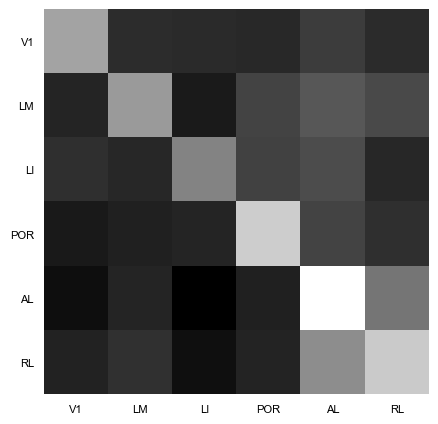

In [8]:
fig2 = plot_generalisation(activity_var, regions, figsize=(3,2), ylabel='Variance')
stats_var = test_significance(activity_var)
# for i in range(len(stats_var)): 
#     print(stats_var[i][i+1] < 0.05)


fig21 = plot_generalisation_simplified(activity_var, regions, figsize=(1.5,2), ylabel='', ylim=(0.2,2.5), yticks=['','','1','','2',''])

fig22 = plot_matrix(activity_var, regions, figsize=(5,5), ylabel='Variance')

if save:
    fig21.savefig(os.path.join(savepath, 'neuron_variance.eps'), bbox_inches='tight')

1    False
2     True
3     True
4    False
5     True
6     True
Name: 1, dtype: bool
1     True
2    False
3     True
4     True
5    False
6     True
Name: 2, dtype: bool
1    False
2     True
3    False
4     True
5     True
6     True
Name: 3, dtype: bool
1     True
2     True
3     True
4    False
5     True
6     True
Name: 4, dtype: bool
1     True
2     True
3     True
4     True
5    False
6    False
Name: 5, dtype: bool
1    False
2    False
3     True
4     True
5     True
6    False
Name: 6, dtype: bool


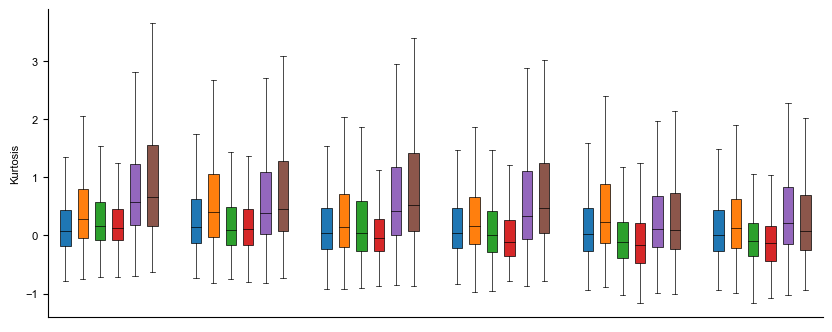

In [9]:
plot_generalisation(activity_kur, regions, figsize=(10,4), ylabel='Kurtosis')
stats_kur = test_significance(activity_kur)
for i in range(len(stats_kur)): 
    print(stats_kur[i][i+1] < 0.05)

V1: MannwhitneyuResult(statistic=8617283.5, pvalue=0.0)
LM: MannwhitneyuResult(statistic=9081660.5, pvalue=0.0)
LI: MannwhitneyuResult(statistic=4657892.5, pvalue=3.027504638124488e-157)
POR: MannwhitneyuResult(statistic=4842135.0, pvalue=2.8620782200960817e-280)
AL: MannwhitneyuResult(statistic=7593902.0, pvalue=0.0)
RL: MannwhitneyuResult(statistic=3008704.0, pvalue=6.545364763693834e-119)


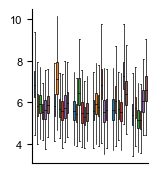

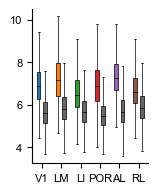

In [10]:
fig3 = plot_generalisation(activity_minmax, regions, figsize=(1.5,2), ylabel='')
stats_minmax = test_significance(activity_minmax)
fig31 = plot_generalisation_simplified(activity_minmax, regions, figsize=(1.5,2), ylabel='')

# for i in range(len(stats_minmax)): 
#     print(stats_minmax[i][i+1] < 0.05)
if save:
    fig31.savefig(os.path.join(savepath, 'response_range.eps'), bbox_inches='tight')

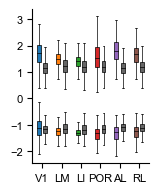

In [11]:
fig9 = plot_percentile(activity_25, activity_75, regions, figsize=(1.5,2), ylabel='')
if save:
    fig9.savefig(os.path.join(savepath, 'response_range_strat.eps'), bbox_inches='tight')

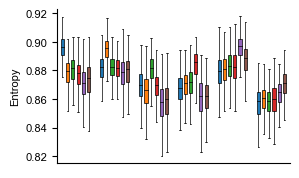

In [12]:
fig3 = plot_generalisation(activity_entr, regions, figsize=(3,2), ylabel='Entropy')

V1: MannwhitneyuResult(statistic=5820556.0, pvalue=1.117147432276497e-202)
LM: MannwhitneyuResult(statistic=5067620.0, pvalue=3.558902282816038e-69)
LI: MannwhitneyuResult(statistic=3906107.0, pvalue=1.9524634666549694e-44)
POR: MannwhitneyuResult(statistic=4592569.5, pvalue=1.9408535021207875e-162)
AL: MannwhitneyuResult(statistic=5709626.0, pvalue=1.5751863071804466e-251)
RL: MannwhitneyuResult(statistic=3700967.5, pvalue=2.2648903422236112e-86)


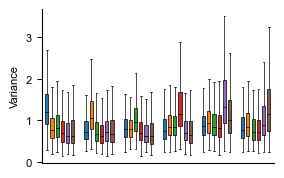

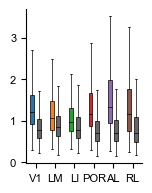

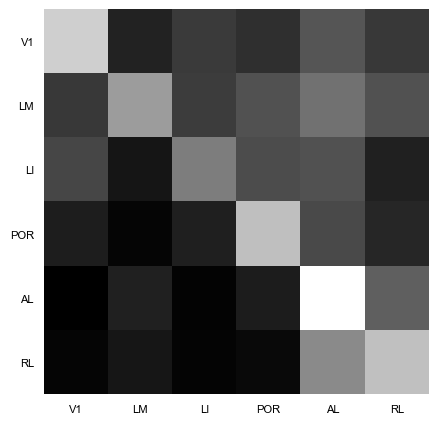

In [13]:
fig4 = plot_generalisation(activity_popvar, regions, figsize=(3,2), ylabel='Variance')
stats_var = test_significance(activity_popvar)
# for i in range(len(stats_var)): 
#     print(stats_var[i][i+1] < 0.05)


fig41 = plot_generalisation_simplified(activity_popvar, regions, figsize=(1.5,2), ylabel='')
#fig41 = plot_generalisation_single(activity_popvar, regions, figsize=(3,2), ylabel='Variance')

fig42 = plot_matrix(activity_popvar, regions, figsize=(5,5), ylabel='Variance')

if save:
    fig41.savefig(os.path.join(savepath, 'neuron_popvariance.eps'), bbox_inches='tight')

## 2. In vivo variance

In [14]:
# Plotting functions
def plot_generalisation_simplified2(data, regions, figsize=(6,5), ylabel='', ylim=None, yticks=None):
    '''Plot a list of boxplots'''
    fig, ax = pl.subplots(figsize=figsize)

    lw = 0.5
    for i, region in enumerate(regions):
        bp1 = ax.boxplot(data[region], showfliers=False, positions=np.arange(1,3)+i*2+i, widths=0.6, 
                        patch_artist=True, medianprops=dict(color='k', linewidth=lw), boxprops=dict(linewidth=lw), whiskerprops=dict(linewidth=lw),
                        capprops=dict(linewidth=lw))

        cs = [colors[i], [.4]*3]
        for patch, color in zip(bp1['boxes'], cs):
            patch.set_facecolor(color)
        
        print(mannwhitneyu(data[region][0], data[region][1]))

    ax.set_ylabel(ylabel)
    ax.set_xlim(0,len(regions)*2+len(regions))
    ax.set_xticks(np.arange(1.5, (len(regions))*3, 3))
    ax.set_xticklabels(regions)

    if ylim is not None:
        ax.set_ylim(ylim)
    if yticks is not None:
        ax.set_yticklabels(yticks)


    return fig

def plot_percentile2(data10, data90, regions, figsize=(6,5), ylabel='', ylim=None, yticks=None):
    '''Plot a list of boxplots'''
    fig, ax = pl.subplots(figsize=figsize)

    lw = 0.5
    for i, region in enumerate(regions):
        bp1 = ax.boxplot(data10[region], showfliers=False, positions=np.arange(1,3)+i*2+i, widths=0.6, 
                        patch_artist=True, medianprops=dict(color='k', linewidth=lw), boxprops=dict(linewidth=lw), whiskerprops=dict(linewidth=lw),
                        capprops=dict(linewidth=lw))

        cs = [colors[i], [.4]*3]
        for patch, color in zip(bp1['boxes'], cs):
            patch.set_facecolor(color)

        bp1 = ax.boxplot(data90[region], showfliers=False, positions=np.arange(1,3)+i*2+i, widths=0.6, 
                        patch_artist=True, medianprops=dict(color='k', linewidth=lw), boxprops=dict(linewidth=lw), whiskerprops=dict(linewidth=lw),
                        capprops=dict(linewidth=lw))

        cs = [colors[i], [.4]*3]
        for patch, color in zip(bp1['boxes'], cs):
            patch.set_facecolor(color)

    ax.set_ylabel(ylabel)
    ax.set_xlim(0,len(regions)*2+len(regions))
    ax.set_xticks(np.arange(1.5, (len(regions))*3, 3))
    ax.set_xticklabels(regions)

    if ylim is not None:
        ax.set_ylim(ylim)
    if yticks is not None:
        ax.set_yticklabels(yticks)

    return fig

def plot_generalisation_single2(data, regions, figsize=(6,5), ylabel=''):
    '''Plot a list of boxplots'''
    fig, ax = pl.subplots(figsize=figsize)

    lw = 0.5
    for i, region in enumerate(regions):
        bp1 = ax.boxplot(data[region][0]/data[region][1], showfliers=False, positions=[1+i*2+i], widths=0.6, 
                        patch_artist=True, medianprops=dict(color='k', linewidth=lw), boxprops=dict(linewidth=lw), whiskerprops=dict(linewidth=lw),
                        capprops=dict(linewidth=lw))

        cs = [colors[i], [.4]*3]
        for patch, color in zip(bp1['boxes'], cs):
            patch.set_facecolor(color)

    ax.axhline(1, ls='--', color=[.5]*3)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0,len(regions)*2+len(regions))
    ax.set_xticks(np.arange(1.5, (len(regions))*3, 3))
    ax.set_xticklabels(regions)

    return fig

In [15]:
invivo_popvar = np.load(r'D:\Data\DeepMouse\Results\tuning_dynamics\popvariance_validation.npy', allow_pickle=True).item()
invivo_neuronvar = np.load(r'D:\Data\DeepMouse\Results\tuning_dynamics\neuronvariance_validation.npy', allow_pickle=True).item()
invivo_popmean = np.load(r'D:\Data\DeepMouse\Results\tuning_dynamics\popmean_validation.npy', allow_pickle=True).item()
invivo_l2 = np.load(r'D:\Data\DeepMouse\Results\tuning_dynamics\L2_validation.npy', allow_pickle=True).item()
invivo_mean = np.load(r'D:\Data\DeepMouse\Results\tuning_dynamics\mean_validation.npy', allow_pickle=True).item()
invivo_10 = np.load(r'D:\Data\DeepMouse\Results\tuning_dynamics\percentile10_validation.npy', allow_pickle=True).item()
invivo_90 = np.load(r'D:\Data\DeepMouse\Results\tuning_dynamics\percentile90_validation.npy', allow_pickle=True).item()

In [16]:
from scipy.stats import wilcoxon
print(wilcoxon(invivo_neuronvar['V1'][0], invivo_neuronvar['V1'][1]))
print(invivo_neuronvar['V1'][0].shape, invivo_neuronvar['V1'][1].shape)

WilcoxonResult(statistic=30698.0, pvalue=3.7705553814255224e-06)
(408,) (408,)


MannwhitneyuResult(statistic=187998.0, pvalue=1.1041999492080145e-07)
MannwhitneyuResult(statistic=566549.0, pvalue=6.294132453068266e-07)
MannwhitneyuResult(statistic=257848.0, pvalue=4.199939191460974e-06)
MannwhitneyuResult(statistic=141412.0, pvalue=3.1346855293087485e-09)
MannwhitneyuResult(statistic=230561.5, pvalue=0.11934733254960082)
MannwhitneyuResult(statistic=33922.0, pvalue=0.00010136436842831978)


c:\Users\rudit\anaconda3\envs\mnp_torch\lib\site-packages\ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


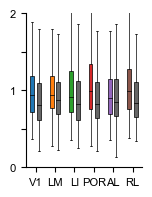

In [17]:
fig5 = plot_generalisation_simplified2(invivo_popvar, regions, figsize=(1.5,2), ylabel='', ylim=(0,2), yticks=['0','','1','','2'])

if save:
    fig5.savefig(os.path.join(savepath, 'neuron_popvariance_invivo.eps'), bbox_inches='tight')

MannwhitneyuResult(statistic=104837.0, pvalue=1.385602839862367e-10)
MannwhitneyuResult(statistic=118863.0, pvalue=1.1727521603159427e-12)
MannwhitneyuResult(statistic=41084.0, pvalue=2.1237735490003648e-05)
MannwhitneyuResult(statistic=20525.0, pvalue=3.653066382614761e-08)
MannwhitneyuResult(statistic=20876.0, pvalue=0.5622587097240328)
MannwhitneyuResult(statistic=15237.0, pvalue=1.537179480628545e-05)


c:\Users\rudit\anaconda3\envs\mnp_torch\lib\site-packages\ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


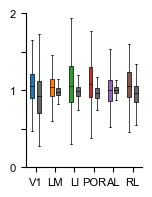

In [18]:
fig6 = plot_generalisation_simplified2(invivo_neuronvar, regions, figsize=(1.5,2), ylabel='', ylim=(0,2), yticks=['0','','1','','2'])

if save:
    fig6.savefig(os.path.join(savepath, 'neuron_variance_invivo.eps'), bbox_inches='tight')

MannwhitneyuResult(statistic=194883.0, pvalue=5.1145709163462725e-11)
MannwhitneyuResult(statistic=558204.0, pvalue=1.221441131813337e-05)
MannwhitneyuResult(statistic=272969.0, pvalue=7.865023409412125e-11)
MannwhitneyuResult(statistic=143686.0, pvalue=1.4347399420586314e-10)
MannwhitneyuResult(statistic=247031.5, pvalue=0.0002166362202228685)
MannwhitneyuResult(statistic=33822.0, pvalue=0.00013285976454002863)


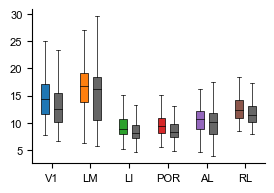

In [19]:
fig7 = plot_generalisation_simplified2(invivo_l2, regions, figsize=(3,2), ylabel='')

if save:
    fig7.savefig(os.path.join(savepath, 'neuron_L2_invivo.eps'), bbox_inches='tight')

MannwhitneyuResult(statistic=200023.0, pvalue=6.032311402307085e-14)
MannwhitneyuResult(statistic=582961.0, pvalue=6.484204920207236e-10)
MannwhitneyuResult(statistic=269455.0, pvalue=1.3513705632658715e-09)
MannwhitneyuResult(statistic=146225.0, pvalue=3.481534594741527e-12)
MannwhitneyuResult(statistic=237695.5, pvalue=0.012954789261660304)
MannwhitneyuResult(statistic=35251.0, pvalue=1.8681846487396217e-06)


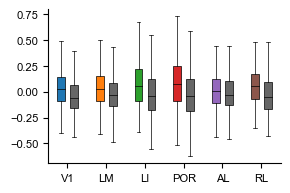

In [20]:
_ = plot_generalisation_simplified2(invivo_mean, regions, figsize=(3,2), ylabel='')


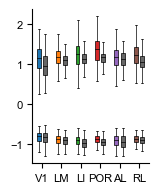

In [21]:
fig10 = plot_percentile2(invivo_10, invivo_90, regions, figsize=(1.5,2), ylabel='')

if save:
    fig10.savefig(os.path.join(savepath, 'neuron_percentile_invivo.eps'), bbox_inches='tight')

## 3. Wdf mean

In [22]:
# Plotting functions
def get_population_mean(data, window=(5,14)):
    '''Given widefield data, extract the mean activity formatted as [region][stimulus]'''
    activity = data['segmented_norm']
    labels = data['labels']

    # Calculate the mean activity 
    activity_m = activity[:,:,window[0]:window[1]].mean(axis=-1)-activity[:,:,:window[0]].mean(axis=-1)

    results = [[activity_m[labels==j,i], activity_m[labels!=j,i]] for i in range(6)]
    return results

def combine_wdf(data):
    '''Combine the data of multiple recordings'''
    combined = []
    for i in range(6):
        within = np.concatenate([d[i][0] for d in data])
        across = np.concatenate([d[i][1] for d in data])
        all_data = np.concatenate([within, across])
        mu, s = all_data.mean(), all_data.std()
        within = (within-mu)/s  
        across = (across-mu)/s
        combined.append([within, across])

    return combined

def plot_wdf(data, figsize=(6,5), ylabel=''):
    '''Plot wdf data as boxplots'''
    fig, ax = pl.subplots(figsize=figsize)

    lw = 0.5
    for i, region in enumerate(regions):
        bp1 = ax.boxplot(data[i], showfliers=False, positions=np.arange(1,3)+i*2+i, widths=0.6, 
                        patch_artist=True, medianprops=dict(color='k', linewidth=lw), boxprops=dict(linewidth=lw), whiskerprops=dict(linewidth=lw),
                        capprops=dict(linewidth=lw))

        cs = [colors[i], [.4]*3]
        for patch, color in zip(bp1['boxes'], cs):
            patch.set_facecolor(color)

    ax.set_ylabel(ylabel)
    ax.set_xlim(0,len(regions)*2+len(regions))
    ax.set_xticks(np.arange(1.5, (len(regions))*3, 3))
    ax.set_xticklabels(regions)
    return fig
    

In [23]:
fp_base = r'D:\Data\DeepMouse\Results\tuning_dynamics'
fps = ['results_RT114.npy', 'results_RT117.npy']

wdf = [np.load(os.path.join(fp_base, name), allow_pickle=True).item() for name in fps]
activity_m = [get_population_mean(data) for data in wdf]
activity_combined = combine_wdf(activity_m)

V1 MannwhitneyuResult(statistic=652110.0, pvalue=0.12520457114338432)
LM MannwhitneyuResult(statistic=656426.0, pvalue=0.07550269350268017)
LI MannwhitneyuResult(statistic=643047.0, pvalue=0.3073993904014086)
POR MannwhitneyuResult(statistic=613766.0, pvalue=0.5251957115000668)
AL MannwhitneyuResult(statistic=649510.0, pvalue=0.16567495219787642)
RL MannwhitneyuResult(statistic=650207.0, pvalue=0.15396726554597004)


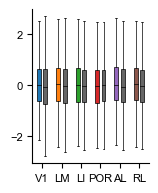

In [30]:
fig7 = plot_wdf(activity_combined, figsize=(1.5,2))

if save:
    fig7.savefig(os.path.join(savepath, 'neuron_mean_invivo.eps'), bbox_inches='tight')

for i, a in enumerate(activity_combined): print(regions[i], mannwhitneyu(a[0], a[1]))
